In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import scipy as sp
import math

In [10]:
from numpy import NaN, nan


data = pd.read_csv("ebola.csv")
#data.DateOnsetInferred = pd.to_datetime(data.DateOnsetInferred, format='%Y-%m-%d')
#data = data[data["DateHospitalCurrentAdmit"] != 'NA']
data = data.dropna(subset=['DateOnsetInferred'])
data

,Country,EpiCaseDef,FinalStatus,DateOnset,DateOnsetInferred,DateReport,DateOutcomeComp,DateHospitalCurrentAdmit,Age,CL_DistrictRes,HospitalizedEver,TreatmentCendreType,TreatmentCentre,delay.onset.hospitalisation,QuarterOnsetInferred,retrospective
0,Guinea,confirmed,Dead,2015-02-06,2015-02-06,2015-02-06,2015-02-06,NaN,45.0,FORECARIAH,No,Not Hospitalised,NaN,NaN,Jan - Mar 2015,True
1,Guinea,confirmed,Dead,2015-03-02,2015-03-02,2015-03-07,2015-03-07,NaN,40.0,CONAKRY,No,Not Hospitalised,NaN,NaN,Jan - Mar 2015,True
2,Guinea,confirmed,Dead,2015-03-15,2015-03-15,2015-03-17,2015-03-18,2015-03-18,0.0,FORECARIAH,Yes,ETU,Conakry 2,3.0,Jan - Mar 2015,False
3,Guinea,confirmed,Dead,2014-06-06,2014-06-06,2014-06-09,2014-06-16,2014-06-09,30.0,GUECKEDOU,Yes,ETU,Gueckedou 1,3.0,Apr - Jun 2014,False
4,Guinea,probable,Dead,2014-02-27,2014-02-27,2014-02-27,2014-03-03,NaN,46.0,GUECKEDOU,Yes,Unknown TC Type,NaN,NaN,Jan - Mar 2014,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33333,Liberia,probable,NaN,2014-10-17,2014-10-17,2014-10-23,NaN,NaN,NaN,MONTSERRADO,NaN,Hospitalisation Unknown,NaN,NaN,Oct - Dec 2014,False
33334,Liberia,confirmed,NaN,NaN,2014-08-17,NaN,NaN,NaN,NaN,NaN,NaN,Hospitalisation Unknown,NaN,NaN,Jul - Sep 2014,False
33335,Liberia,confirmed,NaN,NaN,2014-08-28,NaN,NaN,NaN,26.0,MONTSERRADO,NaN,Hospitalisation Unknown,NaN,NaN,Jul - Sep 2014,False
33336,Liberia,confirmed,NaN,NaN,2015-01-03,NaN,NaN,NaN,NaN,NaN,NaN,Hospitalisation Unknown,NaN,NaN,Jan - Mar 2015,False


In [11]:
from datetime import datetime
def convert_date_to_number(date, earliest_date="2013-12-25"):
    """convert dates to numbers

    Args:
        date (str): String of a date, it should be in format "%d/%m/%Y" 
        earliest_date (str, optional): Date that has value 0. Defaults to "01/01/2011".

    Returns:
        int: Number of days after the earliest_date
    """
    date_format = "%Y-%m-%d"
    delta = datetime.strptime(str(date), date_format) - datetime.strptime(earliest_date, date_format)
    return delta.days
date_nums = data["DateOnsetInferred"].map(convert_date_to_number)
data['datenums'] = date_nums

In [12]:
counts = data.groupby(['datenums']).size()

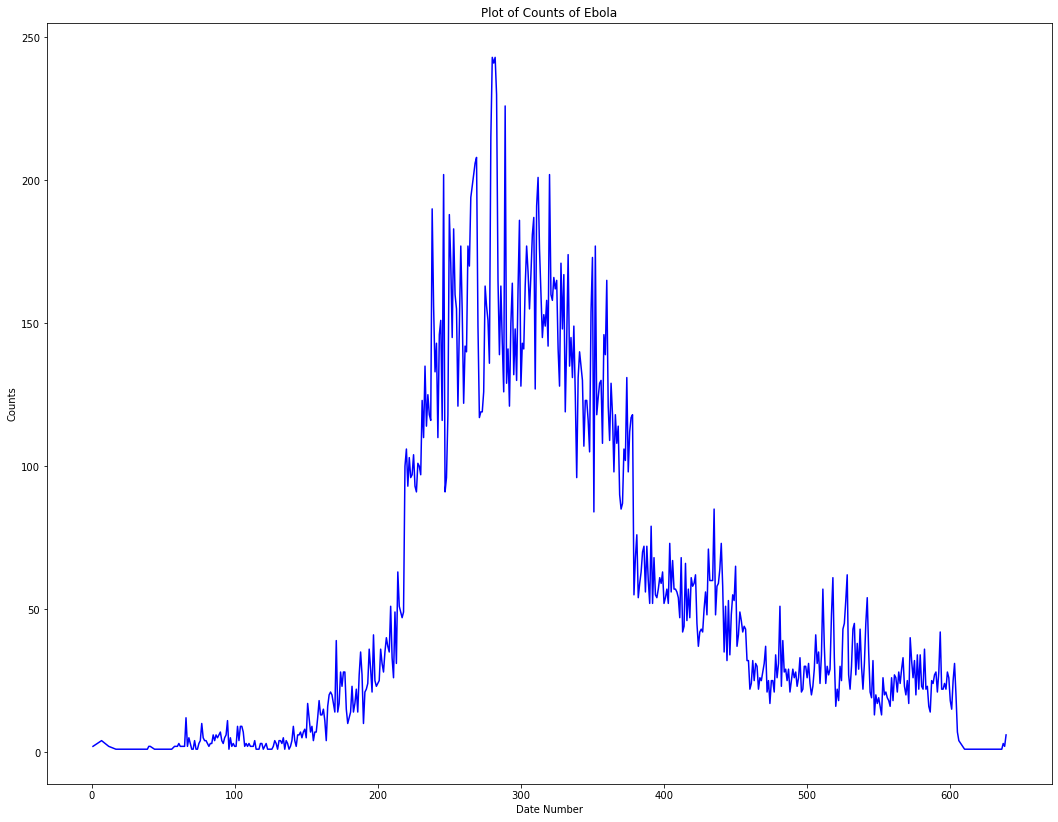

In [18]:
fig = plt.figure(figsize = (18,14))
#fig.set_facecolor('white')
plt.plot(counts,color='b')
plt.xlabel("Date Number")
plt.ylabel("Counts")
plt.title("Plot of Counts of Ebola")
plt.show()

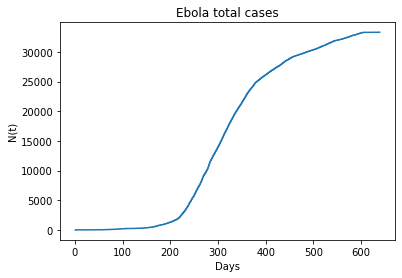

In [16]:
totcounts = range(len(date_nums))
plt.plot(sorted(date_nums), totcounts)
plt.xlabel("Days")
plt.ylabel("N(t)")
plt.title("Ebola total cases")
plt.show()

In [17]:
def distribute(data):
    """Distribute cases in the same day evenly

    Args:
        data (List(int)): A list of event times

    Returns:
        List: Distributed event times
    """
    sorted_el = list(set(date_nums)) 
    sorted_elements = [x + 1 for x in sorted_el]
    time_ticks = []
    for e in sorted_elements:
        count = Counter(data)[e]
        for n in range(count):
            time_ticks.append(int(e)-1+(n+1)/count)
        
    return time_ticks
posdates = date_nums + 1
time_ticks_m = np.asarray(distribute(posdates))

In [27]:
def binary_search(sorted_list, new):
    """Find the right position for a insertion"""
    left = 0
    right = len(sorted_list) - 1

    while left <= right:
        mid = (left + right) // 2
        if sorted_list[mid] == new:
            return mid
        elif sorted_list[mid] < new:
            left = mid + 1
        else:
            right = mid - 1
    return left
#should t not be an event no.
def intensity_lambda_dep(t, time_ticks, phi, lambda0, depth=200):
    """the intensity function (lambda) with depth

    Args:
        t (Float): time
        time_ticks (Iterable): t_i's
        phi (func): phi(kernel function)
        lambda0 (func): Immigrant(?)
        depth (int, optional): In order to save some calculation resourse, only consider the latest few cases. Defaults to 200.

    Returns:
        Float
    """
    pos = binary_search(time_ticks, t)

    # for ind in range(max(0,pos - depth), pos):
    #     self_exciting_term += (phi(t-time_ticks[ind]))
    tterm = t - np.array(time_ticks)
    fi = np.vectorize(phi)
    tterm = fi(tterm)
    self_exciting_term = tterm[max(0,pos - depth): pos))].sum()
    return lambda0(t) + self_exciting_term
#could chop vector and apply function to it then sum

In [28]:
def lambdastarfinder(intensity, paras, lambda0, ti, p):
    lambdastar = 0
    lower = ti
    upper = max(ti + 1/np.sqrt(paras[1]), sp.optimize.f_solve(lambda0))
    return lambdastar



def hawkes_prediction(intensity_func, T_i, p):
    T = T_i * (1 + p)
    event_times = []
    while T_i < T:
        s = np.random.uniform(0, 1)
        if s <= intensity_func(T_i):
            event_times.append(T_i)
        lambda_star = max(0.0000001, intensity_func(T_i))
        u = np.random.uniform(0.0, 1)
        tau = -np.log(u) / lambda_star
        T_i += tau
    return event_times

def prediction(intensity_func, T_i, p=0.5, n=50, time_ticks=time_ticks_m):
    T = T_i * (1 + p)
    N1 = binary_search(time_ticks, T)
    N0 = binary_search(time_ticks, T_i)
    for _ in range(n):
        pred = hawkes_prediction(intensity_func, T_i, p)
        N = len(pred)
        plt.plot(pred, np.arange(N+N0)[-N:], color="k", alpha=0.15)
    plt.plot(time_ticks[:N1], totcounts[:N1], label="data", color="r")
    plt.xlabel("Time")
    plt.ylabel("N(t)")
    plt.legend()
    
    plt.show()

In [29]:
def lambda0(t, A=0.4, B=0.0001, M=0.305, N=-0.123, p=1/365.25):
    return max(A + B*t + M*np.cos(2 * np.pi * t * p) + N*np.sin(2 * np.pi * t * p), 0)

def phi(t, a=0.22, d=0.28):
    return a * t * np.exp(-d*(t**2)/2)

def intensity_lambda(t):
    return intensity_lambda_dep(t, time_ticks_m, phi, lambda0, depth=100)

In [30]:
def intensity_lambda_opt(t, para):
    return intensity_lambda_dep(t, time_ticks_m, lambda t: phi(t, a=para[0], d=para[1]),
                                lambda t: lambda0(t, A=para[2], B=para[3], M=para[4], N=para[5]), depth=100)

In [31]:
para_500 = [0.34370721287574196, 0.33838309225679053, 15.477674416858854,
            -0.17994521525248847, -12.669382975946965, -10.421908839961313]
para_1000 = [0.24655667005503992, 0.24687170893153007, 18.48608388425914,
             -0.18653454460526345, -15.577491370875672, -10.834512161391528]
para_2000 = [0.0339681, 0.03393125, 19.18181993,
             -0.18969188, -14.90572887, -10.80625601]
para_2500 = [1.50557197e-02, 1.47657330e-02, -1.53924292e+02, -5.94169115e-01,
             1.57346515e+02, 3.52598336e+01]
para_3000 = [1.51423538e-02, 1.48368207e-02, -1.53925484e+02, -5.94254838e-01,
             1.57345363e+02,3.52598791e+01]

In [32]:
prediction(lambda t:intensity_lambda_opt(t, para_500), time_ticks_m[500])

KeyboardInterrupt: 

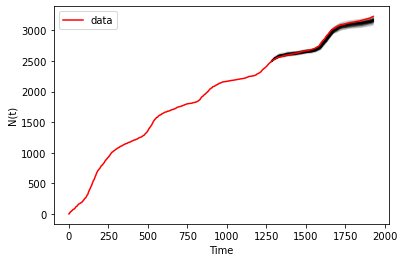

In [154]:
prediction(lambda t:intensity_lambda_opt(t, para_2500), time_ticks_m[2500])